<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_008_diabetes_tspg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
import numpy as np
print(np.__version__)

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
1.26.4


In [2]:
# Dependencies
import numpy as np
import scipy
import os
import re
import string
import pandas as pd
from collections import Counter
import sklearn
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
!pip install gensim
from gensim.models import Word2Vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [4]:
!pip install subgroups
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.2/306.2 kB 18.2 MB/s eta 0:00:00


In [5]:
!git clone https://github.com/uef-machine-learning/tspgclu.git
%cd tspgclu
!pip install -r requirements.txt
!pip install .
!python python/ex_cluster.pyimport tspg
import tspg

Cloning into 'tspgclu'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 228 (delta 127), reused 161 (delta 66), pack-reused 0 (from 0)
Receiving objects: 100% (228/228), 8.39 MiB | 8.92 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/tspgclu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.5 MB/s eta 0:00:00
Processing /content/tspgclu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tspg: filename=tspg-1.0-cp311-cp311-linux_x86_64.whl size=536188 sha256=c5752601034cbbbf38d88cfaa7249d3b5e27c65945b16a70d3dc339d62ec35a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-tsh01bwo/wheels/76/b6/67/20b88094c0a7504d3e162a7729d9ab59dad6b547bc230d033f
Successfully built tspg
python3: can't open file '/content/tspgclu/pyth

In [19]:
#SDUEBA Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""

vector_space_dimension = 100
n_clusters = 45
clustering_method = "tspg"      #"agglomerative"/"spherical_kmeans"/"tspg"
frac_of_dataset = 1

max_depth = 2
test_size = 0.2
mixed_threshold = 0.9
tree_accuracy_threshold = 0.95

#Quality metric parameters
description_length_limit = 3
difference_limit = 0
subgroup_size_limit = 200

In [20]:
#Best feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

def create_shorter_sample(df, frac=None):
    df_sampled = df.sample(frac=frac, random_state=73)
    df_sampled = df_sampled.reset_index(drop=True)
    return df_sampled

# drive.mount('/content/drive')
#'/content/drive/MyDrive/Colab Notebooks/diabetes_preprocessed.csv'

file_path = '/content/diabetes_preprocessed.csv'

df = create_shorter_sample(pd.read_csv(file_path), frac=frac_of_dataset)
df = df.drop(columns=['readmitted', 'readmit_30_days'])
df_encoded = df.copy()
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

imputer = SimpleImputer(strategy="most_frequent")
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

X = df_imputed.drop(columns=["readmit_binary"])
y = df_imputed["readmit_binary"]

model = RandomForestClassifier(n_estimators=100, random_state=73)
model.fit(X, y)

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
top_features = feature_importances.sort_values(by='Importance', ascending=False).head(30)

top_features

<ipython-input-20-ff95480ede51>:16: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = create_shorter_sample(pd.read_csv(file_path), frac=frac_of_dataset)


,Feature,Importance
10,num_lab_procedures,0.084400
51,diag_2_desc,0.077922
52,diag_3_desc,0.077696
50,primary_diag_desc,0.077416
12,num_medications,0.073897
7,time_in_hospital,0.053144
2,age,0.043970
16,number_diagnoses,0.037460
9,medical_specialty,0.036478
8,payer_code,0.036408


In [21]:
#Data augemntation
def create_quantile_categorical_feature(df, feature_name):

    if feature_name not in df.columns:
        print(f"Error: Feature '{feature_name}' not found in DataFrame.")
        return df

    num_quantiles = 5
    quantiles = np.linspace(0, 1, num_quantiles + 1)
    bins = df[feature_name].quantile(quantiles).tolist()
    bins[-1] = float('inf')

    bins = sorted(list(set(bins)))

    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

    if len(bins) - 1 < 5:
        labels = labels[:len(bins) - 1]

    df[f'{feature_name}_category'] = pd.cut(df[feature_name], bins=bins, labels=labels, include_lowest=True, duplicates='drop')
    df = df.drop(columns=[feature_name])

    return df

features_raw = df[[feature for feature in top_features['Feature']]]

target_df = df[['readmit_binary']]
target_df.loc[:, 'readmit_binary'] = target_df['readmit_binary'].replace({True: 'Yes', False: 'No', 'True': 'Yes', 'False': 'No'})

for column in ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'number_diagnoses', 'num_procedures', 'number_inpatient', 'number_outpatient', 'number_emergency']:
    features_raw = create_quantile_categorical_feature(features_raw, column)


features_raw.head()

<ipython-input-21-b91a8f1391b6>:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Yes' 'No' 'No' ... 'Yes' 'No' 'Yes']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  target_df.loc[:, 'readmit_binary'] = target_df['readmit_binary'].replace({True: 'Yes', False: 'No', 'True': 'Yes', 'False': 'No'})
<ipython-input-21-b91a8f1391b6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{feature_name}_category'] = pd.cut(df[feature_name], bins=bins, labels=labels, include_lowest=True, duplicates='drop')


,diag_2_desc,diag_3_desc,primary_diag_desc,age,medical_specialty,payer_code,discharge_disposition,discharge_disposition_id,insulin,race,...,glyburide,diabetesMed,num_lab_procedures_category,num_medications_category,time_in_hospital_category,number_diagnoses_category,num_procedures_category,number_inpatient_category,number_outpatient_category,number_emergency_category
0,Diabetes mellitus without mention of complicat...,"Extrinsic asthma, unspecified","Depressive disorder, not elsewhere classified",[80-90),NaN,NaN,Discharged to home,1,No,Caucasian,...,Steady,Yes,High,Medium,Very High,Medium,Very Low,Very Low,Very Low,Very Low
1,Secondary malignant neoplasm of kidney,Secondary malignant neoplasm of lung,Malignant neoplasm of trachea,[60-70),Emergency/Trauma,MC,Discharged/transferred to SNF,3,No,Caucasian,...,No,No,High,Medium,High,Medium,Low,Very Low,Very Low,Very Low
2,"Acute gastritis, without mention of hemorrhage",Internal hemorrhoids without mention of compli...,Postinflammatory pulmonary fibrosis,[50-60),Family/GeneralPractice,NaN,Discharged/transferred to home with home healt...,6,Down,AfricanAmerican,...,No,Yes,Very Low,Very High,High,Medium,Medium,Very Low,Very Low,Very Low
3,Diabetes mellitus without mention of complicat...,Malignant essential hypertension,Coronary atherosclerosis of unspecified type o...,[50-60),Cardiology,MC,Discharged to home,1,Steady,AfricanAmerican,...,No,Yes,Medium,Medium,Low,Very Low,Medium,Very Low,Very Low,Very Low
4,"Chronic airway obstruction, not elsewhere clas...",Need for prophylactic vaccination and inoculat...,"Diabetes with hyperosmolarity, type II or unsp...",[50-60),NaN,NaN,Discharged/transferred to SNF,3,Up,Caucasian,...,No,Yes,Very High,Very High,Low,Medium,Very Low,Very Low,Very Low,Very Low


In [22]:
# Sentence creation
training_df = pd.merge(features_raw, target_df, left_index=True, right_index=True).astype(str)

for column in training_df.columns:
    split_columns = column.split("_")
    jointed_columns = ' '.join(split_columns)

    def transform_value(x):
        values = [f"{jointed_columns} is {val.strip()}" for val in x.split(',')]
        return ', '.join(values)

    training_df[column] = training_df[column].apply(transform_value)

sentences = training_df.apply(lambda row: list(row), axis=1).tolist()

print(sentences[0])

['diag 2 desc is Diabetes mellitus without mention of complication, diag 2 desc is type II or unspecified type, diag 2 desc is not stated as uncontrolled', 'diag 3 desc is Extrinsic asthma, diag 3 desc is unspecified', 'primary diag desc is Depressive disorder, primary diag desc is not elsewhere classified', 'age is [80-90)', 'medical specialty is nan', 'payer code is nan', 'discharge disposition is Discharged to home', 'discharge disposition id is 1', 'insulin is No', 'race is Caucasian', 'had inpatient days is True', 'gender is Female', 'A1Cresult is nan', 'admission type is Urgent', 'admission type id is 2', 'metformin is No', 'admission source is Emergency Room', 'glipizide is No', 'change is No', 'admission source id is 7', 'glyburide is Steady', 'diabetesMed is Yes', 'num lab procedures category is High', 'num medications category is Medium', 'time in hospital category is Very High', 'number diagnoses category is Medium', 'num procedures category is Very Low', 'number inpatient c

In [23]:
#Word2Vec training and clustering
#https://journalofbigdata.springeropen.com/articles/10.1186/s40537-024-01053-x
class Word2VecModel:
    def __init__(self, sentences, vector_size, window=5, min_count=1):
        self.model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)

    def get_embedding(self, sentence):
        word_embeddings = [self.model.wv[word] for word in sentence if word in self.model.wv]
        return np.mean(word_embeddings, axis=0) if word_embeddings else np.zeros(self.model.vector_size)

class SentenceEmbedder:
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model

    def generate_embeddings(self, sentences, normalize=False):
        embeddings = np.array([self.word2vec_model.get_embedding(sentence) for sentence in sentences])
        return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) if normalize else embeddings

class SphericalKMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        X = normalize(X, norm='l2', axis=1)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.cluster_centers_ = X[indices]

        for _ in range(self.max_iter):
            similarities = X @ self.cluster_centers_.T
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([
                normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                if np.any(labels == j) else self.cluster_centers_[j]
                for j in range(self.n_clusters)
            ]).squeeze()

            if np.linalg.norm(new_centroids - self.cluster_centers_) < self.tol:
                break

            self.cluster_centers_ = new_centroids

        self.labels_ = labels
        return self

    def predict(self, X):
        X = normalize(X, norm='l2', axis=1)
        similarities = X @ self.cluster_centers_.T
        return np.argmax(similarities, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

class ClusteringModel:
    def __init__(self, n_clusters, method="spherical_kmeans", random_state=42):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.model = self._initialize_model()

    def _initialize_model(self):
        if self.method == "agglomerative":
            return AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average')
        elif self.method == "spherical_kmeans":
            return SphericalKMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        elif self.method == "tspg":
            return self
        else:
            raise ValueError("Unsupported clustering method")

    def fit_predict(self, embeddings):
        if self.method == "tspg":
            return self._tspg_clustering(embeddings)
        return self.model.fit_predict(embeddings)

    def _tspg_clustering(self, embeddings):
        labels, _ = tspg.tspg(embeddings.tolist(), self.n_clusters, distance="cos", num_tsp=30, dtype="vec")
        labels = [x-1 for x in labels]
        return np.array(labels)

word2vec_model = Word2VecModel(sentences, vector_size=vector_space_dimension)
sentence_embedder = SentenceEmbedder(word2vec_model)
embeddings = sentence_embedder.generate_embeddings(sentences, normalize=True)
clustering_model = ClusteringModel(n_clusters, method=clustering_method)
labels = clustering_model.fit_predict(embeddings)

In [24]:
#Decision tree training
class DecisionTreeTrainer:
    def __init__(self, features_raw, labels, max_depth, subgroup_size_limit, test_size, random_state=73, print_acc=True):
        self.features_raw = features_raw
        self.labels = labels
        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc

        self.encoder = OneHotEncoder()
        self.decision_trees = {}
        self.accuracies = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        features_classify = self.features_raw.assign(cluster=self.labels)
        X = features_classify.drop(columns=['cluster'])
        X_encoded = self.encoder.fit_transform(X)
        y = features_classify['cluster']

        self.X_df = pd.DataFrame(X_encoded.toarray(), columns=self.encoder.get_feature_names_out())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_df, y, test_size=self.test_size, random_state=self.random_state, stratify=y
            )

    def _train_trees(self):
        for cluster in sorted(self.y_train.unique()):
            y_train_binary = (self.y_train == cluster).astype(int)
            y_test_binary = (self.y_test == cluster).astype(int)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.subgroup_size_limit, random_state=self.random_state)
            clf.fit(self.X_train, y_train_binary)

            self.decision_trees[cluster] = clf

            y_pred = clf.predict(self.X_test)
            accuracy = accuracy_score(y_test_binary, y_pred)
            self.accuracies[cluster] = accuracy

            if self.print_acc:
                print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
                print(classification_report(y_test_binary, y_pred))

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

tree_trainer = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)

In [25]:
# Subgroup creation and quality evaluation
def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    difference = abs(tp / (tp + fp) - (TP / (TP + FP)))
    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN
    return difference / description_length

class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, mixed_threshold, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold):
        self.data_frame = data_frame
        self.target_df = target_df
        self.mixed_threshold = mixed_threshold
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}

        self.target_column = target_df.columns[0]
        self._extract_rules_for_clusters()

    def _extract_rules_from_tree(self, tree, node=0, rule_list=None, rule_path=None):
        if rule_list is None:
            rule_list = []
        if rule_path is None:
            rule_path = []

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            class_probabilities = value[0] / value.sum()
            predicted_class = class_probabilities.argmax()
            rule_list.append(" AND ".join(rule_path))
            return rule_list

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, rule_list, rule_path + [f"{self.feature_names[feature]} <= {threshold:.2f}"])

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, rule_list, rule_path + [f"{self.feature_names[feature]} > {threshold:.2f}"])

        return rule_list

    def _extract_rules_for_clusters(self):
        cluster_class_counts = {}
        for i, cluster in enumerate(self.cluster_labels):
            class_label = self.target_df[self.target_column][i]
            cluster_class_counts.setdefault(cluster, {}).setdefault(class_label, 0)
            cluster_class_counts[cluster][class_label] += 1

        N = len(self.target_df)
        class_counts = {class_: sum(self.target_df[self.target_column] == class_) for class_ in set(self.target_df[self.target_column])}
        n_dict = {}

        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            class_percentages = {cls: round(count / total_count, 2) for cls, count in class_counts.items()}

            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = class_percentages
            self.tp_dict[cluster] = max(class_counts.values())
            self.fp_dict[cluster] = total_count - self.tp_dict[cluster]
            n_dict[cluster] = total_count

            self.TP_dict[cluster] = self.tp_dict[cluster]
            self.FP_dict[cluster] = N - self.tp_dict[cluster]
            self.WRAcc_dict[cluster] = ((self.tp_dict[cluster] + self.fp_dict[cluster]) / N) * (self.tp_dict[cluster] / n_dict[cluster] - self.TP_dict[cluster] / N)

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy lower than the given threshold"]
                else:
                    rules_list = self._extract_rules_from_tree(self.decision_trees[cluster])
                    self.rules_dict[cluster] = rules_list if rules_list else self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)

    def print_summary(self):
        print("\nFormatted Cluster Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            percentages_str = ", ".join(f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items())
            rules = self.rules_dict.get(cluster, None)

            if rules is None:
                rules = ["No rules extracted"]

            print(f"Cluster {cluster}: support = {self.cluster_frequencies[cluster]}, {percentages_str}, WRAcc = {self.WRAcc_dict[cluster]}")

            for rule in rules:
                print(f"  - {rule}")

        print("\nUnextractable Clusters:", self.unextractable_clusters)


clusters = ClusterRuleExtractor(
    data_frame=training_df,
    target_df=target_df,
    mixed_threshold=mixed_threshold,
    cluster_labels=labels,
    feature_names=list(tree_trainer.X_df.columns),
    decision_trees=tree_trainer.get_trees(),
    trees_acc=tree_trainer.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold
)
clusters.print_summary()


Formatted Cluster Summary:
Cluster 0: support = 1247, 'No': 0.55, 'Yes': 0.45, WRAcc = 0.006619529546662787
  - discharge_disposition_nan <= 0.50 AND diag_2_desc_Pleurisy without mention of effusion or current tuberculosis <= 0.50
  - discharge_disposition_nan <= 0.50 AND diag_2_desc_Pleurisy without mention of effusion or current tuberculosis > 0.50
  - discharge_disposition_nan > 0.50 AND admission_type_Emergency <= 0.50
  - discharge_disposition_nan > 0.50 AND admission_type_Emergency > 0.50
Cluster 1: support = 836, 'Yes': 0.57, 'No': 0.43, WRAcc = 0.00461948121983819
  - admission_type_id_6 <= 0.50 AND glipizide_Down <= 0.50
  - admission_type_id_6 <= 0.50 AND glipizide_Down > 0.50
  - admission_type_id_6 > 0.50 AND admission_source_ Emergency Room <= 0.50
  - admission_type_id_6 > 0.50 AND admission_source_ Emergency Room > 0.50
Cluster 2: support = 1104, 'No': 0.55, 'Yes': 0.45, WRAcc = 0.005948556185981497
  - admission_type_Urgent <= 0.50 AND admission_type_nan <= 0.50
  - ad

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


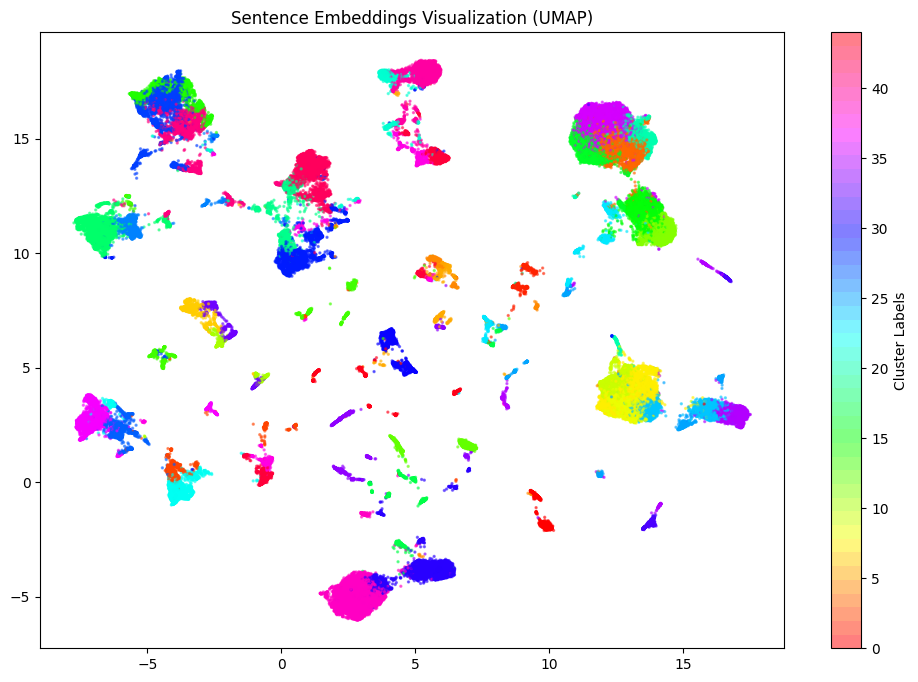

In [26]:
# Clusters visualization
import umap
def plot_sentence_embeddings(embeddings, cluster_labels, clustering_method=None):
    plt.figure(figsize=(12, 8))

    reducer = umap.UMAP(n_components=2, random_state=73, n_neighbors=15, min_dist=0.1)
    embeddings_2d = reducer.fit_transform(np.array(embeddings))

    cluster_labels = np.array(cluster_labels)

    cmap = plt.get_cmap('hsv', len(set(cluster_labels)))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=cmap, alpha=0.5, s=2)

    plt.colorbar(scatter, label='Cluster Labels')
    plt.title(f"Sentence Embeddings Visualization ({clustering_method})")
    plt.show()

plot_sentence_embeddings(embeddings, cluster_labels=labels, clustering_method='UMAP')

In [27]:
class SubgroupCreator:
    def __init__(self, X_df, targets_df, target_value):
        self.X_df = X_df
        self.targets_df = targets_df
        self.target_value = target_value
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.total_coverage = 0

    def evaluate_rule(self, rule_str, covered_indices_set):
        parts = rule_str.split(" AND ")
        mask = pd.Series(True, index=self.X_df.index)

        description = []

        for part in parts:
            feature, operator, value = part.rsplit(maxsplit=2)
            value = float(value)

            if ">" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} = '{category_value}'")
                mask &= self.X_df[feature] > 0.5

            elif "<=" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} ≠ '{category_value}'")
                mask &= self.X_df[feature] <= 0.5

        covered_indices = set(self.X_df[mask].index) - covered_indices_set
        covered_indices_set.update(covered_indices)
        covered_targets = self.targets_df.loc[list(covered_indices)]

        tp = (covered_targets == self.target_value).sum().item()
        fp = (covered_targets != self.target_value).sum().item()
        TP = (self.targets_df == self.target_value).sum().item()
        FP = (self.targets_df != self.target_value).sum().item()

        WRAcc = ((tp + fp) / (TP + FP)) * ((tp / (tp + fp)) - (TP / (TP + FP)))

        return tp, fp, TP, FP, WRAcc, covered_indices, description
    def evaluate_all_clusters(self, subgroups):
        with open("results_SDUEBA.txt", "w") as f:
            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster not in subgroups.unextractable_clusters:
                    covered_indices_set = set()

                    for idx, rule_str in enumerate(rules_list):
                        letter_index = string.ascii_lowercase[idx]
                        subgroup_label = f"{cluster}.{letter_index}"

                        tp, fp, TP, FP, WRAcc, covered_indices, description = self.evaluate_rule(rule_str, covered_indices_set)

                        self.tp_dict[subgroup_label] = tp
                        self.fp_dict[subgroup_label] = fp
                        self.TP_dict[subgroup_label] = TP
                        self.FP_dict[subgroup_label] = FP
                        self.WRAcc_dict[subgroup_label] = WRAcc
                        self.subgroups[subgroup_label] = covered_indices
                        self.total_coverage += tp + fp

                        description_str = ", ".join(str(item) for item in description)
                        self.Quality_dict[subgroup_label] = Quality_metric(
                            tp=tp,
                            fp=fp,
                            TP=TP,
                            FP=FP,
                            description_length=len(description),
                            description_length_limit=description_length_limit,
                            difference_limit=difference_limit,
                            subgroup_size_limit=subgroup_size_limit,
                        )

                        f.write(
                            f"Description: [{description_str}], Target: class = '{self.target_value}' ; "
                            f"QuMe = {float(self.Quality_dict[subgroup_label]) if self.Quality_dict[subgroup_label] is not None else 0:.8f} ; "
                            f"WRAcc = {float(WRAcc) if WRAcc is not None else 0:.8f} ; "
                            f"tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                        )
            f.write(f"Total coverage: {self.total_coverage / len(self.targets_df)}\n")


evaluator = SubgroupCreator(tree_trainer.X_df, target_df, target_value='Yes')
evaluator.evaluate_all_clusters(clusters)

In [15]:
%%time
from subgroups.algorithms import BSD
from subgroups.quality_measures import WRAcc
from subgroups.quality_measures import WRAccOptimisticEstimate1

dataset = pd.concat([features_raw, target_df], axis=1).astype(str)
target = ('readmit_binary', 'Yes')
print(len(dataset))

bsd_model = BSD(min_support=0, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=100, max_depth=2, write_results_in_file = True, file_path = "./results_BSD.txt" )
bsd_model.fit(dataset, target)


101766
CPU times: user 29min 29s, sys: 4.61 s, total: 29min 34s
Wall time: 30min 2s


In [16]:
def parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit):
    output_file = "results_BSD_.txt"

    with open(file_path, 'r') as file, open(output_file, 'w') as output:
        for line in file:
            match = re.search(r"(Description: \[.*?\]), Target: (.*?) ; Quality Measure WRAcc = ([\d.-]+) ; tp = (\d+) ; fp = (\d+) ; TP = (\d+) ; FP = (\d+)", line)

            if match:
                description = match.group(1)
                target = match.group(2)
                WRAcc = float(match.group(3))
                tp = int(match.group(4))
                fp = int(match.group(5))
                TP = int(match.group(6))
                FP = int(match.group(7))

                description_text = description[13:-1]
                description_length = description_text.count(',') + 1 if description_text else 1

                quality_score = Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit)

                output_line = f"{description}, Target: {target} ; QuMe = {quality_score:.8f} ; WRAcc = {WRAcc:.8f} ; tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                output.write(output_line)

file_path = "results_BSD.txt"
parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit)

In [31]:
#coverage and overlap ratio
def compute_coverage(filename, quality_measure, k, dataset_size, print_subgroups=False):
    with open(filename, 'r') as file:
        lines = file.readlines()

    subgroups = []
    instance_coverage = {}

    for line in lines:
        match = re.search(rf"{quality_measure}\s*=\s*([-+]?\d*\.?\d+)\s*;.*tp\s*=\s*(\d+)\s*;\s*fp\s*=\s*(\d+)", line)
        if match:
            quality = float(match.group(1))
            tp = int(match.group(2))
            fp = int(match.group(3))

            desc_match = re.search(r"Description: \[(.*?)\]", line)
            if desc_match:
                description = desc_match.group(1).split(", ")
            else:
                description = []

            mask = pd.Series(True, index=dataset.index)
            for condition in description:
                try:
                    feature, value = condition.split(" = ")
                    value = value.strip("'")

                    if feature not in dataset.columns:
                        continue

                    mask &= dataset[feature] == value
                except ValueError:
                    continue

            covered_instances = set(dataset[mask].index)

            for instance in covered_instances:
                instance_coverage[instance] = instance_coverage.get(instance, 0) + 1

            subgroups.append((quality, covered_instances, description, line.strip()))

    subgroups.sort(reverse=True, key=lambda x: x[0])
    top_k_subgroups = subgroups[:k]

    covered_instances = set()
    filtered_instance_coverage = {}

    for _, instance_ids, _, _ in top_k_subgroups:
        covered_instances.update(instance_ids)
        for instance in instance_ids:
            filtered_instance_coverage[instance] = filtered_instance_coverage.get(instance, 0) + 1

    coverage = len(covered_instances) / len(dataset) if len(dataset) else 0
    overlapping_instances = sum(1 for count in filtered_instance_coverage.values() if count > 1)
    overlap_ratio = overlapping_instances / len(covered_instances) if covered_instances else 0

    if print_subgroups:
        print("Top-k subgroups:")
        for _, _, _, subgroup in top_k_subgroups:
            print(subgroup)

    return coverage, overlap_ratio

print("SDUEBA model:")
coverage_SDUEBA, overlap_SDUEBA = compute_coverage('results_SDUEBA.txt', 'QuMe', 25, len(target_df), True)
print(f"Coverage: {coverage_SDUEBA}, Overlap Ratio: {overlap_SDUEBA}")

print("BSD model:")
coverage_BSD, overlap_BSD = compute_coverage('results_BSD_.txt', 'QuMe', 25, len(target_df), True)
print(f"Coverage: {coverage_BSD}, Overlap Ratio: {overlap_BSD}")

SDUEBA model:
Top-k subgroups:
Description: [discharge_disposition_id ≠ '7', discharge_disposition = 'Expired'], Target: class = 'Yes' ; QuMe = 0.23044042 ; WRAcc = -0.00743634 ; tp = 0 ; fp = 1642 ; TP = 46902 ; FP = 54864
Description: [discharge_disposition ≠ 'Discharged/transferred to another rehab fac including rehab units of a hospital .', discharge_disposition = 'Expired'], Target: class = 'Yes' ; QuMe = 0.23044042 ; WRAcc = -0.00743634 ; tp = 0 ; fp = 1642 ; TP = 46902 ; FP = 54864
Description: [discharge_disposition_id ≠ '4', discharge_disposition_id = '11'], Target: class = 'Yes' ; QuMe = 0.23044042 ; WRAcc = -0.00743634 ; tp = 0 ; fp = 1642 ; TP = 46902 ; FP = 54864
Description: [admission_type_id ≠ '3', primary_diag_desc = 'Obesity, unspecified'], Target: class = 'Yes' ; QuMe = 0.16480336 ; WRAcc = -0.00083887 ; tp = 34 ; fp = 225 ; TP = 46902 ; FP = 54864
Description: [admission_source_id = '6', discharge_disposition = 'Discharged to home'], Target: class = 'Yes' ; QuMe = 0